### LDA for captions Extracted from Images using the image_captioning model
Latent Dirichlet Allocation (LDA) is a three-level hierarchical Bayesian model for topic inference. 

#### Libraries

In [1]:
#Libraries for files
#from pandas import DataFrame

from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import spatial

import re,   gensim
#from pandasql import *

# libraries for TFIDF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(2018)
#nltk.download('wordnet')


import gensim
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint


# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn



Importing the posted captions from the pickled database built by Arun

In [2]:
#Read the pickle database to get the columns for the object descriptions

import pickle

with open('instagram_database_reuters_3.pickle', 'rb') as f:
    data = pickle.load(f)

df=DataFrame(data)
df.head()


,username,postid,date,url,img_link,vid_link,caption,location_name,location_link,likes,views,image_caption,combined_caption
0,NULL,BkH69K-n1v9,2018-06-17T11:16:17.000Z,https://www.instagram.com/p/BkH69K-n1v9/,https://scontent-dfw5-1.cdninstagram.com/vp/1c...,None,People gather for an open-air yoga session nea...,NULL,NULL,8715,NONE,"a crowd of people standing on top of a field, ...",People gather for an open-air yoga session nea...
1,NULL,BembSYkHbeT,2018-01-31T04:27:39.000Z,https://www.instagram.com/p/BembSYkHbeT/,https://scontent-dfw5-1.cdninstagram.com/vp/27...,None,"North Korean defector Ji Seong-ho, currently a...",NULL,NULL,3458,NONE,a group of men standing next to each other in ...,"North Korean defector Ji Seong-ho, currently a..."
2,NULL,BpUCo6xj3ct,2018-10-24T10:51:17.000Z,https://www.instagram.com/p/BpUCo6xj3ct/,https://scontent-dfw5-1.cdninstagram.com/vp/60...,None,Men work on cables connecting power transmissi...,NULL,NULL,8232,NONE,a group of people riding skis on top of a ski ...,Men work on cables connecting power transmissi...
3,NULL,BjKcT5UH2b_,2018-05-24T14:14:50.000Z,https://www.instagram.com/p/BjKcT5UH2b_/,https://scontent-dfw5-1.cdninstagram.com/vp/3d...,None,A mahout rides his elephant in the Yamuna rive...,NULL,NULL,9371,NONE,"a man riding an elephant in the water, a man i...",A mahout rides his elephant in the Yamuna rive...
4,NULL,BczdWEFnkQr,2017-12-17T12:52:58.000Z,https://www.instagram.com/p/BczdWEFnkQr/,https://scontent-dfw5-1.cdninstagram.com/vp/f8...,None,Photographers take pictures as the Soyuz MS-07...,NULL,NULL,6184,NONE,a group of people standing next to each other ...,Photographers take pictures as the Soyuz MS-07...


In [3]:
# Create an index to refer to a sample post later as a sample document 
df['index']=data.index

# select only the variables needed in this model and create a df: 
documents = df[['image_caption', 'likes' ,'index']]
documents.head()


,image_caption,likes,index
0,"a crowd of people standing on top of a field, ...",8715,0
1,a group of men standing next to each other in ...,3458,1
2,a group of people riding skis on top of a ski ...,8232,2
3,"a man riding an elephant in the water, a man i...",9371,3
4,a group of people standing next to each other ...,6184,4


Remove non-text caracters in case they exist in the text post: 

In [4]:

doc = documents.image_caption

# Remove Emails
doc = [re.sub('\S*@\S*\s?', '', sent) for sent in doc]

# Remove new line characters
doc = [re.sub('\s+', ' ', sent) for sent in doc]

# Remove distracting single quotes
doc = [re.sub("\'", "", sent) for sent in doc]
# Remove #
doc = [re.sub("\#", "", sent) for sent in doc]

# Remove /
doc = [re.sub("\/", "", sent) for sent in doc]

pprint(doc[:1])

['a crowd of people standing on top of a field, a crowd of people standing on '
 'top of a sandy beach, a crowd of people standing on top of a lush green '
 'field, ']


#### Tokenization

Tokenizing using gensim library: as it has a function simple_preprocess()
Breaking up the posted text into sentences. 
After that we will tokenize each sentence into a list of words.
Gensim’s simple_preprocess() is great for this. 
deacc=True to remove the punctuations.

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words =tuple( sent_to_words(doc))

print(data_words[:1])

(['crowd', 'of', 'people', 'standing', 'on', 'top', 'of', 'field', 'crowd', 'of', 'people', 'standing', 'on', 'top', 'of', 'sandy', 'beach', 'crowd', 'of', 'people', 'standing', 'on', 'top', 'of', 'lush', 'green', 'field'],)


#### Lemmatization

Lemmatization : converting words to its root word.
The advantage of this is, we get to reduce the total number of unique words in the dictionary. 
As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns. You can expect better topics to be generated in the end.

In [6]:

stemmer = PorterStemmer()



def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result



In [7]:
# sample document at index 3 is being tested to see if our tokenizer and lammitizer work:

doc_sample = documents[documents['index'] == 3].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')

# apply the function we defined earlier to test the sample doc:
print(preprocess(doc_sample))


original document: 
['a', 'man', 'riding', 'an', 'elephant', 'in', 'the', 'water,', 'a', 'man', 'is', 'riding', 'an', 'elephant', 'in', 'the', 'water,', 'a', 'man', 'riding', 'on', 'the', 'back', 'of', 'an', 'elephant,', '']


 tokenized and lemmatized document: 
['rid', 'eleph', 'water', 'rid', 'eleph', 'water', 'rid', 'eleph']


In [8]:
#Since the test document worked we can apply to the whole set of documents we have
#Preprocess the caption text, saving the results as "data_lemmatized"

data_lemmatized  = documents['image_caption'].map(preprocess)
data_lemmatized[:10]

0    [crowd, peopl, stand, field, crowd, peopl, sta...
1    [group, stand, room, group, peopl, stand, tabl...
2    [group, peopl, rid, ski, slope, group, peopl, ...
3    [rid, eleph, water, rid, eleph, water, rid, el...
4    [group, peopl, stand, snow, cover, field, grou...
5    [stand, christma, tree, clock, stand, christma...
6    [babi, eleph, stand, bigger, eleph, babi, elep...
7    [drive, road, park, meter, drive, street, park...
8    [group, stand, field, group, stand, beach, gro...
9    [crowd, peopl, walk, street, hold, umbrella, g...
Name: image_caption, dtype: object

The training dataset for LDA topic model algorithm requires a document word matrix as the main input.
To create one, we will use CountVectorizer. 
In the below code, we chose to convert all words to lowercase, and remove stopwords.



Since most cells contain zeros, the result will be in the form of a sparse matrix to save memory.
If you want to materialize it in a 2D array format, call the todense() method of the sparse matrix like its done in the next step.

In [9]:
# configuring the vectorizer
vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, stop_words="english", analyzer='word',  max_df=1.0, min_df=1, max_features=2000)

#APplying the the transform to our data in order to get the word matrix
data_vectorized = vectorizer.fit_transform(data_lemmatized)



8. Check the Sparsicity
Sparsicity is refering to the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.


In [10]:
#Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")


Sparsicity:  1.5754132231404958 %


#### Build LDA model with sklearn
The Latent Dirichlet Allocation (LDA) model needs to be initialised first and then we call fit_transform() to build the LDA model.
For start we set the number of topics(n-componenets) as 20 based on prior knowledge about the dataset. Later we will find the optimal number using grid search.


In [11]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


#### Model performance 
Two common measure for LDA performance measure:
1- perplexity(small is better) and 2- log-likelihood (hihg is better)


In [12]:

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())


Log Likelihood:  -32170.870540039523
Perplexity:  53.12742771060756
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### How to GridSearch the best LDA model?

The most important tuning parameter , in order of priority ,for LDA models is: 1- n_components (number of topics). 
2- I am going to search learning_decay (which controls the learning rate) .
3- learning_offset (downweigh early iterations. Should be > 1) and 4- max_iter. 

The grid search constructs multiple LDA models for all possible combinations of param values in the param_grid dict. So, this process can consume a lot of time and resources.

In [13]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30,50,100], 'learning_decay': [.5, .7, .9]}

In [14]:
#Supress warnings
import warnings
warnings.filterwarnings("ignore")

# Init the Model
lda = LatentDirichletAllocation()


# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)


# Do the Grid Search
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30, 50, 100], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_decay': [0.5, 0.7, 0.9], 'n_topics': [10, 15, 20, 25, 30, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

#### How to see the best topic model and its parameters?

In [15]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -13439.443032650232
Model Perplexity:  58.427950230327426


#### Compare LDA Model Performance Scores

In [16]:
# Get Log Likelyhoods from Grid Search Output
n_topics =[10, 15, 20, 25, 30, 50, 100]

log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]


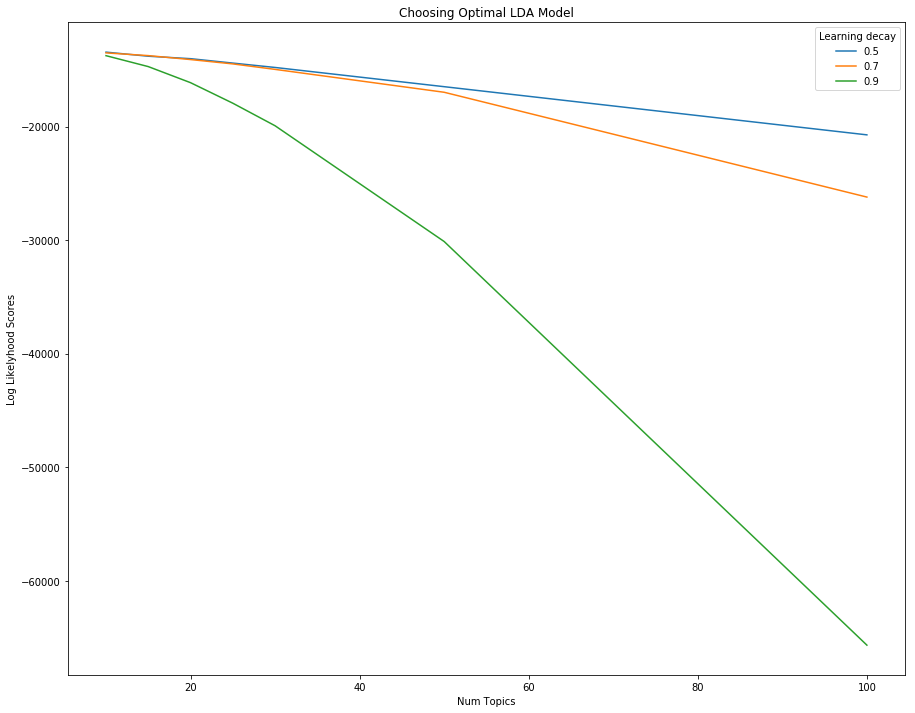

In [17]:
# Show graph
plt.figure(figsize=(15, 12))

plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


From the above plots : Plotting the log-likelihood scores against num_topics, clearly shows number of topics = 20 has better scores. And learning_decay of 0.7 outperforms both 0.5 and 0.9.
We are thinking the reason is : even though we know that the dataset has 20 distinct topics to start with, some topics could share common keywords. For example, ‘paparazi’ and ‘photographers’ can have a lot of common words. 

So the bottom line is, a lower optimal number of distinct topics (even 10 topics) may be reasonable for this dataset. 

### How to see the dominant topic in each document?
To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.
In the table below,  all major topics in a document are written in "Green" and assigned the most dominant topic in its own column.

In [30]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames)#, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic


# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
#df_document_topics.head

In [31]:
df_document_topics.data.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
0,0.01,0.01,0.01,0.01,0.01,0.01,0.58,0.37,0.01,0.01,6
1,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.91,0.01,0.01,7
2,0.01,0.01,0.65,0.01,0.01,0.01,0.31,0.01,0.01,0.01,2
3,0.01,0.01,0.37,0.21,0.01,0.01,0.01,0.34,0.01,0.01,2
4,0.01,0.01,0.01,0.01,0.01,0.01,0.94,0.01,0.01,0.01,6


In [32]:
df_document_topics_with_likes = pd.concat((df_document_topics.data, documents['likes']), axis=1)
df_document_topics_with_likes.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic,likes
0,0.01,0.01,0.01,0.01,0.01,0.01,0.58,0.37,0.01,0.01,6,8715
1,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.91,0.01,0.01,7,3458
2,0.01,0.01,0.65,0.01,0.01,0.01,0.31,0.01,0.01,0.01,2,8232
3,0.01,0.01,0.37,0.21,0.01,0.01,0.01,0.34,0.01,0.01,2,9371
4,0.01,0.01,0.01,0.01,0.01,0.01,0.94,0.01,0.01,0.01,6,6184


In [34]:
df_document_topics_with_likes.to_pickle('image_cap_document_topics_with_likes.pickle')

### 15. Topics distribution across documents


In [33]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution


,Topic Num,Num Documents
0,6,143
1,7,107
2,2,104
3,9,76
4,8,72
5,0,54
6,3,43
7,1,35
8,5,34
9,4,25


### Visualize the LDA model with pyLDAvis
In pyLDAvis, there is a dynamic visualization of topics-keywords distribution:
A good topic model will have non-overlapping, fairly big sized blobs for each topic.Let's see what we will get here.

In [28]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel


PreparedData(topic_coordinates=            Freq  cluster  topics          x           y
topic                                                   
6      19.769806        1       1 -30.112335  -23.101774
2      13.605407        1       2  84.785583  147.219147
7      13.272249        1       3 -28.838516   86.780418
9      10.977104        1       4 -82.181145   38.656536
8      10.704916        1       5  38.587238   95.927048
3       7.364058        1       6  99.660835   56.259850
0       7.357958        1       7  62.462914  -16.492468
5       6.208438        1       8  12.671675   32.934776
1       5.568840        1       9 -81.800575  131.307648
4       5.171224        1      10  -1.719651  162.289902, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
287   Default  566.000000       stand  566.000000  30.0000  30.0000
135   Default  581.000000       group  581.000000  29.0000  29.0000
211   Default  464.000000       peopl  464.000000  28.0000  28.0000
262   Default  292.000000         sit  292.000000  27.0000  27.0000
242   Default  276.000000         rid  276.000000  26.0000  26.0000
347   Default  188.000000       woman  188.000000  25.0000  25.0000
148   Default  167.000000        hold  167.000000  24.0000  24.0000
108   Default  163.000000         fli  163.000000  23.0000  23.0000
69    Default  112.000000       clock  112.000000  22.0000  22.0000
49    Default  126.000000       build  126.000000  21.0000  21.0000
169   Default  140.000000        larg  140.000000  20.0000  20.0000
351   Default   77.000000       young   77.000000  19.0000  19.0000
212   Default  129.000000      person  129.000000  18.0000  18.0000
294   Default  132.000000      street  132.000000  17.0000  17.0000
275   Default  101.000000        snow  101.000000  16.0000  16.0000
164   Default   61.000000        kite   61.000000  15.0000  15.0000
30    Default   75.000000        bird   75.000000  14.0000  14.0000
321   Default   62.000000       tower   62.000000  13.0000  13.0000
31    Default   74.000000       black   74.000000  12.0000  12.0000
265   Default   84.000000  skateboard   84.000000  11.0000  11.0000
23    Default  114.000000       beach  114.000000  10.0000  10.0000
105   Default  118.000000       field  118.000000   9.0000   9.0000
150   Default   56.000000        hors   56.000000   8.0000   8.0000
338   Default   90.000000       water   90.000000   7.0000   7.0000
213   Default   62.000000       phone   62.000000   6.0000   6.0000
60    Default   58.000000        cell   58.000000   5.0000   5.0000
25    Default   81.000000       bench   81.000000   4.0000   4.0000
38    Default   51.000000        bodi   51.000000   3.0000   3.0000
83    Default   77.000000       cover   77.000000   2.0000   2.0000
110   Default   45.000000       flock   45.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
261   Topic10    8.264917        sign    9.125977   2.8630  -3.9253
158   Topic10    6.300818      jetlin    7.163045   2.8338  -4.1966
292   Topic10    5.972711       store    6.833796   2.8274  -4.2501
47    Topic10    5.965990       brush    6.826874   2.8273  -4.2512
350   Topic10    5.868703      yellow    6.729772   2.8252  -4.2677
306   Topic10    5.032918       swing    5.893803   2.8042  -4.4213
231   Topic10    4.219417      racket    5.080332   2.7764  -4.5976
139   Topic10    3.752827        hang    4.613764   2.7555  -4.7148
319   Topic10    3.647228       tooth    4.508122   2.7501  -4.7433
18    Topic10    3.501409        base    4.362415   2.7422  -4.7841
269   Topic10    3.501330       slide    4.362406   2.7422  -4.7842
21    Topic10    3.203404      bathro    4.065004   2.7239  -4.8731
254   Topic10    3.098744        seat    3.959919   2.7168  -4.9063
96    Topic10    3.098682      driver    3.959913   2.7168  -4.9063
59    Topic10    2.755183        ceil    3.616099   2.6901  -5.0238
312   Top

### How to see the Topic’s keywords?
The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().
Let’s use this info to construct a weight matrix for all keywords in each topic.

In [29]:

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,action,adult,advertis,airpla,airplan,airport,anim,appl,area,arm,...,white,width,wind,window,wine,woman,wood,wooden,yellow,young
Topic0,0.100011,0.100013,0.100009,0.100011,0.100010,0.100008,0.100012,1.557228,0.100098,0.100008,...,5.519686,0.100010,0.100009,0.100010,0.100009,0.100021,0.100025,0.100015,0.100058,0.100008
Topic1,0.100011,0.100010,0.100009,0.928219,4.696664,0.100010,0.100010,0.100014,0.100008,0.100010,...,0.100015,1.380748,0.100244,2.274006,0.100010,0.100315,0.100010,0.100009,0.100009,0.100012
Topic2,0.100009,0.100010,0.100008,0.100018,0.100013,0.100011,0.100012,0.100010,0.100026,0.100009,...,0.100009,0.100011,0.100012,0.100011,0.100009,0.106573,0.100016,0.100011,0.100100,0.103577
Topic3,0.100010,0.100009,0.100010,0.100008,32.398749,14.580122,0.100011,0.100009,0.100010,0.100010,...,0.100192,0.100011,0.100009,0.100012,0.100011,0.100010,0.100008,0.100051,0.100008,0.101944
Topic4,1.868719,0.740348,1.980998,0.100008,0.100017,0.100032,0.100012,0.100008,0.100011,0.100009,...,4.126020,0.100022,1.468780,1.492239,0.100009,0.100046,0.100007,0.100010,5.532428,0.105689


### Top 15 keywords each topic:
From the above output, we will try to see the top 15 keywords that are representative of the topic.
The show_topics() defined below creates that.
       


In [30]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15) 

In [31]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,street,hors,middl,road,statu,park,citi,rid,bunch,hydrant,brown,build,forest,dirt,truck
Topic 1,kite,fli,train,bridg,view,beach,river,mountain,person,track,travel,lake,pink,rang,background
Topic 2,rid,person,snow,skateboard,cover,ski,street,slope,surfboard,snowboard,board,motorcycl,umbrella,bike,wave
Topic 3,fli,bird,water,flock,bodi,larg,airplan,ramp,plane,laptop,fighter,airport,beach,blue,runway
Topic 4,build,larg,tenni,mirror,dress,court,player,racquet,sign,jetlin,store,brush,yellow,swing,play
Topic 5,clock,young,tower,wear,larg,backgrou,children,citi,middl,pictur,tall,frisbe,frisb,play,background
Topic 6,group,peopl,stand,field,beach,walk,boat,water,sandi,street,green,kit,surfboard,play,herd
Topic 7,stand,group,peopl,tabl,room,eleph,girl,build,crowd,coupl,umbrella,chair,littl,cake,bride
Topic 8,sit,black,white,bear,bench,lay,tabl,teddi,anim,shirt,stuff,photo,wooden,close,littl
Topic 9,woman,hold,sit,phone,cell,suit,bench,talk,hand,basebal,couch,toothbrush,pair,scissor,banana
